In [1]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,roc_auc_score,precision_recall_curve,classification_report,auc
from sklearn.model_selection import learning_curve,cross_val_score,LearningCurveDisplay
import joblib

In [2]:
# load train and test datasets
x_train = pd.read_parquet('data/x_train.parquet')
y_train = pd.read_parquet('data/y_train.parquet')['y_train']
x_test = pd.read_parquet('data/x_test.parquet')
y_test = pd.read_parquet('data/y_test.parquet')['y_test']

In [4]:
# load the best model 
best_model = joblib.load('models/XGB Classifier_best_model.pkl')

In [20]:
# preform predictions using a custom threshold of 0.3 
y_pred_proba = best_model.predict_proba(x_test)[:,1]
threshold = 0.7
y_pred = (y_pred_proba >= threshold).astype(int)

In [21]:
# cross validation across the 5 folds of training, return the mean and std cv score
cv_score = cross_val_score(best_model,x_train,y_train,cv=5,scoring='f1_macro',n_jobs=-1,verbose=2)
print('F1 score across folds: ',cv_score)
print('Mean score : ', cv_score.mean())
print('Standard deviation : ',cv_score.std())

# Insights: 
# Small standard deviation and similar ranges of values across 5 folds suggests that the model is stable 

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


F1 score across folds:  [0.80740782 0.82350655 0.81691958 0.8110862  0.81642496]
Mean score :  0.8150690206756455
Standard deviation :  0.0054956693327632665


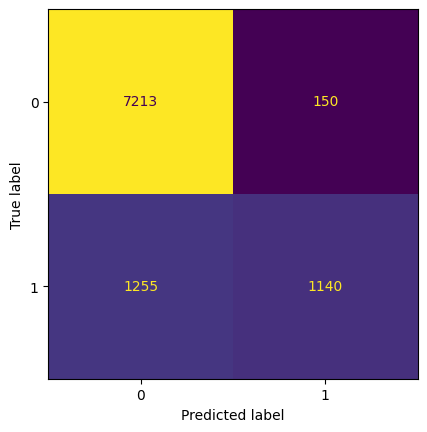

In [22]:
# 1. Model evaluation 
# Confusion matrix - analyse classifications and misclassifications of labels through visuals
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(cm,display_labels=best_model.classes_)
disp.plot(cmap='viridis',colorbar=False)
plt.show()

In [ ]:
# 2. Learning Curve - A visual plot of how the model learns - bias and variance tradeoff
train_sizes, train_score, test_score = learning_curve(
    best_model,x_train,y_train,cv = 5, scoring='f1_macro'
)
disp = LearningCurveDisplay(train_sizes=train_sizes,
                            train_scores=np.mean(train_score,axis=1),
                            test_scores=np.mean(test_score,axis=1))
plt.legend()
plt.title('Learning Curve')
plt.show()

In [19]:
# 3. Log loss - loss function for some classification models
from sklearn.metrics import log_loss
print('Log Loss : ',log_loss(y_test,y_pred))

Log Loss :  4.934855598264041
